In [ ]:
import os
import pathlib

import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    MaxPooling2D,
    Dropout,
    Resizing,
    Input,
    Normalization,
)
from keras import models
import matplotlib.pyplot as plt
from IPython import display
import pyaudio
import wave

In [ ]:
DATASET_PATH = "data/"

data_dir = pathlib.Path(DATASET_PATH)


tf.keras.utils.get_file(
    "voicedataset.zip",
    origin="http://aiolearn.com/dl/datasets/voicedata.zip",
    extract=True,
    cache_dir=".",
    cache_subdir="data",
)

print("DONE!")

In [ ]:
tf.io.gfile.listdir(str(data_dir))

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[
    (commands != "README.md")
    & (commands != ".DS_Store")
    & (commands != "voicedataset.zip")
]
print("Commands Available:", commands)

In [ ]:
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset="both",
)

label_names = np.array(X_train.class_names)
print()
print("label :", label_names)

In [56]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test = X_test.map(squeeze, tf.data.AUTOTUNE)

In [57]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [58]:
val = X_test
X_test = X_test.shard(num_shards=2, index=0)
val = X_test.shard(num_shards=2, index=1)

In [62]:
for x, y in X_train.take(1):
    print(x)

    print(label_names[y])

tf.Tensor(
[[ 2.3498535e-03  2.9296875e-03  3.4179688e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.4038086e-03 -1.8920898e-03 -1.8005371e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ... -5.4931641e-04
  -3.6621094e-04 -5.4931641e-04]
 ...
 [-1.5258789e-04 -1.8310547e-04 -1.2207031e-04 ...  1.8310547e-04
   2.1362305e-04  2.7465820e-04]
 [-1.8310547e-04 -2.4414062e-04 -3.3569336e-04 ... -2.4414062e-04
  -2.1362305e-04 -2.4414062e-04]
 [-4.6691895e-03 -1.5502930e-02 -1.5594482e-02 ... -2.5573730e-02
  -1.7059326e-02 -1.2817383e-02]], shape=(64, 16000), dtype=float32)
['right' 'down' 'down' 'right' 'up' 'yes' 'left' 'go' 'stop' 'stop' 'down'
 'left' 'left' 'up' 'yes' 'go' 'up' 'stop' 'yes' 'yes' 'yes' 'right' 'up'
 'right' 'stop' 'up' 'up' 'yes' 'yes' 'no' 'up' 'stop' 'no' 'up' 'right'
 'left' 'go' 'up' 'yes' 'stop' 'stop' 'up' 'down' 'no' 'left' 'left' 'no'
 'right' 'left' 'yes' 'go' 'right' 'right' 'up' 'up' 'go' 

In [64]:
for example_audio, example_labels in X_train.take(1):
    print(example_audio.shape)

    print(example_labels.shape)

(64, 16000)
(64,)


In [65]:
label_names[[0, 1, 2]]

array(['down', 'go', 'left'], dtype='<U5')

In [66]:
example_audio[0][5100]

<tf.Tensor: shape=(), dtype=float32, numpy=0.23016357421875>

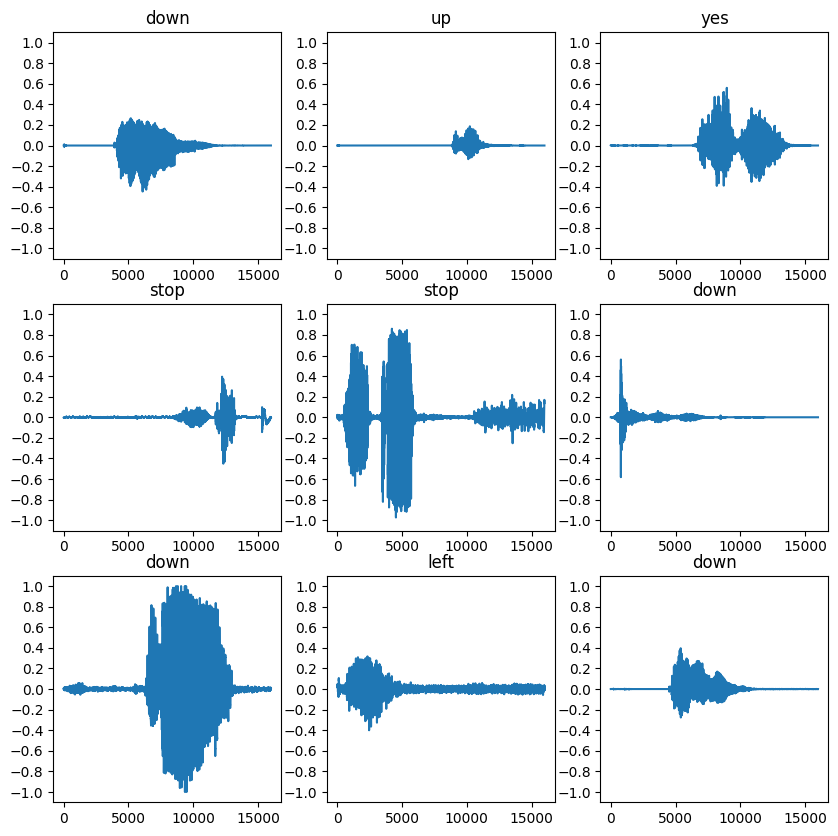

In [67]:
plt.figure(figsize=(10, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [68]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [70]:
for i in range(5):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print("Label:", label)
    print("Waveform shape:", waveform.shape)
    print("Spectrogram shape:", spectrogram.shape)
    print("Audio playback")
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [71]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

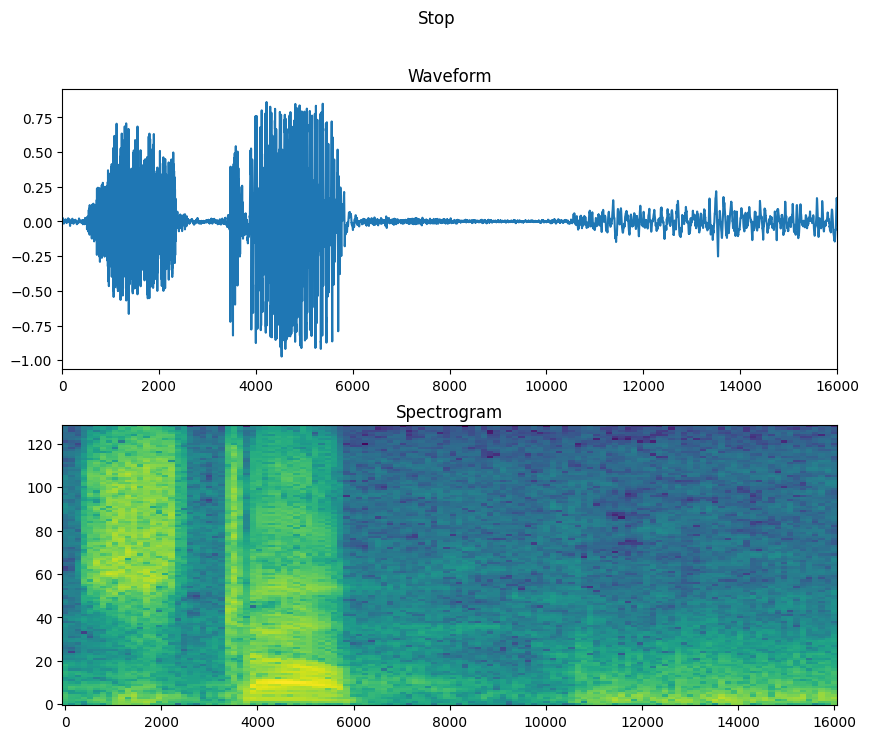

In [74]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title("Spectrogram")

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [75]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

In [76]:
train_spectrogram_ds = make_spec_ds(X_train)
val_spectrogram_ds = make_spec_ds(val)
test_spectrogram_ds = make_spec_ds(X_test)

In [85]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [79]:
train_spectrogram_ds = (
    train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [80]:
example_spectrograms.shape[1:]

TensorShape([124, 129, 1])

In [101]:
input_shape = example_spectrograms.shape[1:]
print("Input shape:", input_shape)
num_labels = len(label_names)

norm_layer = Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        Input(shape=input_shape),
        # Downsample the input.
        Resizing(32, 32),
        # Normalize.
        norm_layer,
        Conv2D(32, 3, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(8),
    ]
)

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [102]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [103]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.2916 - loss: 1.9288 - val_accuracy: 0.6016 - val_loss: 1.3171
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5584 - loss: 1.2607 - val_accuracy: 0.7109 - val_loss: 0.9447
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6728 - loss: 0.9326 - val_accuracy: 0.7422 - val_loss: 0.7492
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7483 - loss: 0.7420 - val_accuracy: 0.7760 - val_loss: 0.6567
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7853 - loss: 0.6166 - val_accuracy: 0.7995 - val_loss: 0.5641
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8131 - loss: 0.5153 - val_accuracy: 0.8125 - val_loss: 0.5521
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8335 - loss: 0.4737 - val_accuracy: 0.8281 - val_loss: 0.5432
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8606 - loss: 0.3869 - val_accu

Text(0, 0.5, 'Accuracy [%]')

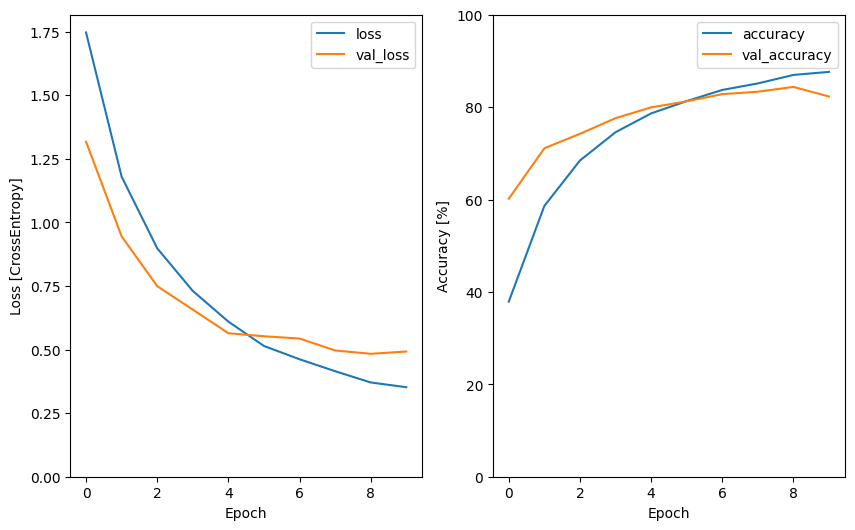

In [104]:
metrics = history.history
plt.close()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1, 2, 2)
plt.plot(
    history.epoch,
    100 * np.array(metrics["accuracy"]),
    100 * np.array(metrics["val_accuracy"]),
)
plt.legend(["accuracy", "val_accuracy"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [105]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8750 - loss: 0.3723

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8417 - loss: 0.4443


{'accuracy': 0.84375, 'loss': 0.45171135663986206}

In [106]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [107]:
y_pred = tf.argmax(y_pred, axis=1)

In [108]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

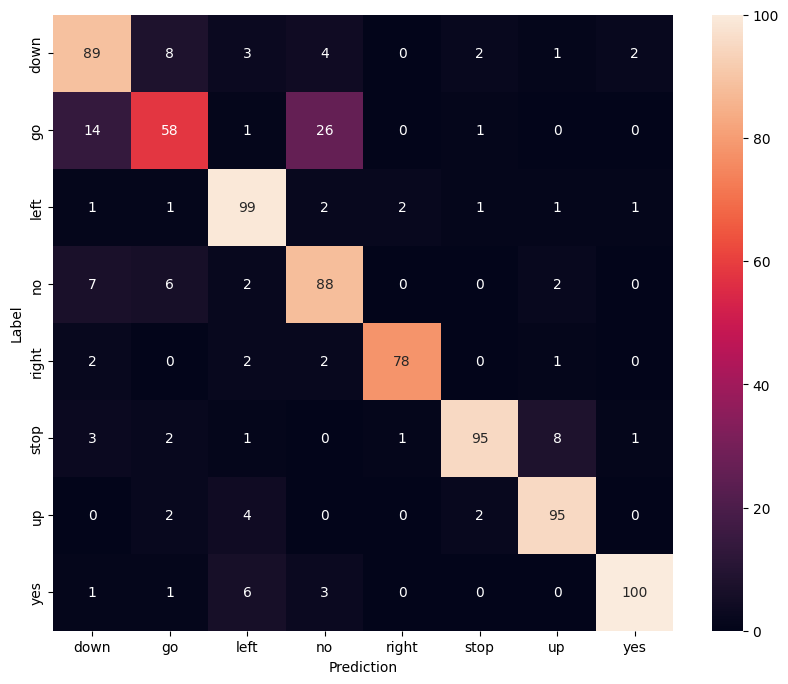

In [109]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

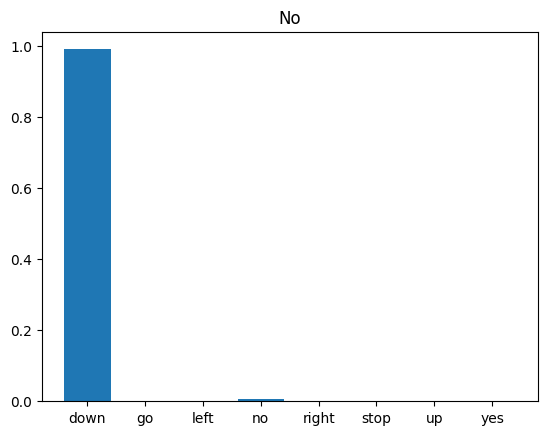

In [ ]:
x = "data/down/0a9f9af7_nohash_0.wav"
x = tf.io.read_file(str(x))

plt.close()

x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)

x = tf.squeeze(x, axis=-1)

waveform = x

x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)

x_labels = label_names
plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title("No")
plt.show()
display.display(display.Audio(waveform, rate=16000, autoplay=True))

In [ ]:
x = "data/down/0a9f9af7_nohash_0.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)
x = tf.squeeze(x, axis=-1)
waveform = x
display.display(display.Audio(waveform, rate=16000, autoplay=True))

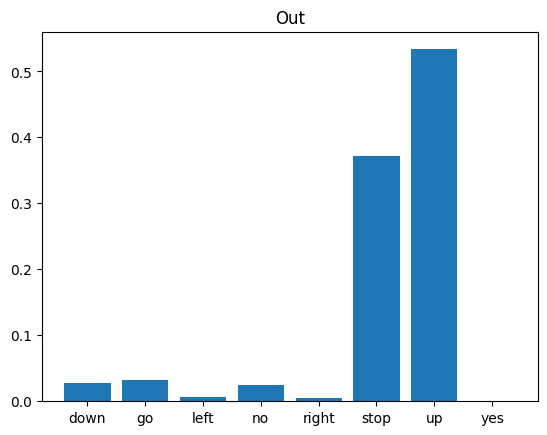

In [ ]:
p = pyaudio.PyAudio()
sabad = 16000
stream = p.open(
    format=pyaudio.paInt16, channels=1, rate=16000, input=True, frames_per_buffer=sabad
)
a = stream.read(sabad)


wf = wave.open("majid.wav", "wb")
wf.setnchannels(1)
wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
wf.setframerate(16000)
wf.writeframes(b"".join([a]))
wf.close()

x = "majid.wav"
x = tf.io.read_file(str(x))

x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = label_names


plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title("Out")
plt.show()

In [140]:
model.save("model.h5")